# Non-linear dimension reduction to diffusion maps

Here we reduce the dimensions of a trajectory into a diffusion map.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 0.17.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests

<div class="alert alert-info">
    
**Note**

Please cite <a data-cite="coifman_diffusion_2006" href="https://doi.org/10.1016/j.acha.2006.04.006">Coifman and Lafon, 2006</a> if you use the ``MDAnalysis.analysis.diffusionmap.DiffusionMap`` in published work.

</div>


In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import diffusionmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>). The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)

/home/pbarletta/mambaforge/envs/mda-user-guide/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Diffusion maps

Diffusion maps are a non-linear dimensionality reduction technique that embeds the coordinates of each frame onto a lower-dimensional space, such that the distance between each frame in the lower-dimensional space represents their “diffusion distance”, or similarity. It integrates local information about the similarity of each point to its neighours, into a global geometry of the intrinsic manifold. This means that this technique is not suitable for trajectories where the transitions between conformational states are not well-sampled (e.g. replica exchange simulations), as the regions may become disconnected and a meaningful global geometry cannot be approximated. Unlike [principal component analysis](pca.ipynb), there is no explicit mapping between the components of the lower-dimensional space and the original atomic coordinates; no physical interpretation of the eigenvectors is immediately available. 
Please see <a data-cite="coifman_diffusion_2006" href="https://doi.org/10.1016/j.acha.2006.04.006">Coifman and Lafon, 2006</a>, <a data-cite="de_la_porte_introduction_2008" href="#References">Porte *et al.*, 2008</a>, <a data-cite="rohrdanz_determination_2011" href="https://doi.org/10.1063/1.3569857">Rohrdanz *et al.*, 2011</a> and <a data-cite="ferguson_nonlinear_2011" href="https://doi.org/10.1016/j.cplett.2011.04.066">Ferguson *et al.*, 2011</a> for more information.

The default distance metric implemented in MDAnalysis' DiffusionMap class is RMSD.

<div class="alert alert-info">
    
**Note**

MDAnalysis implements RMSD calculation using the fast QCP algorithm (<a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a>). Please cite <a data-cite="theobald_rapid_2005" href="https://doi.org/10.1107/S0108767305015266">Theobald, 2005</a> if you use the default distance metric in published work.

</div>


In [3]:
dmap = diffusionmap.DiffusionMap(u, select='backbone', epsilon=2)
dmap.run()

The first eigenvector in a diffusion map is always essentially all ones (when divided by a constant):

In [4]:
dmap._eigenvectors[:, 0]

array([0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101525,
       0.10101525, 0.10101525, 0.10101525, 0.10101525, 0.10101

Therefore, when we embed the trajectory onto the dominant eigenvectors, we ignore the first eigenvector. In order to determine which vectors are dominant, we can examine the eigenvalues for a **spectral gap**: where the eigenvalues stop decreasing constantly in value.

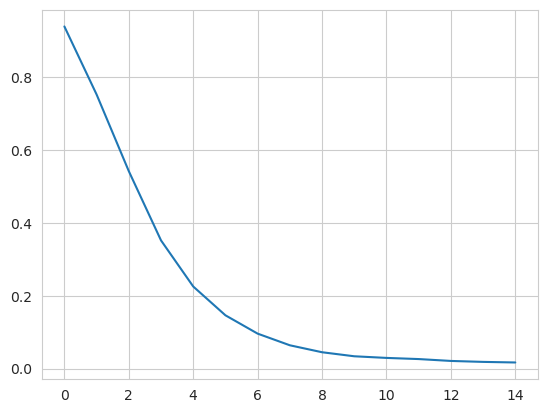

In [5]:
fig, ax = plt.subplots()
ax.plot(dmap.eigenvalues[1:16])

From this plot, we take the first *k* dominant eigenvectors to be the first five. Below, we transform the trajectory onto these eigenvectors. The ``time`` argument is the exponent that the eigenvalues are raised to for embedding. As values increase for ``time``, more dominant eigenvectors (with lower eigenvalues) dominate the diffusion distance more. The ``transform`` method returns an array of shape (# frames, # eigenvectors).

In [6]:
transformed = dmap.transform(5,  # number of eigenvectors
                     time=1)
transformed.shape

(98, 5)

For easier analysis and plotting we can turn the array into a DataFrame.

In [7]:
df = pd.DataFrame(transformed, 
                  columns=['Mode{}'.format(i+2) for i in range(5)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,Mode2,Mode3,Mode4,Mode5,Mode6,Time (ps)
0,0.094795,0.075950,0.054708,0.035526,0.022757,0.0
1,0.166068,0.132017,0.094409,0.060914,0.038667,1.0
2,0.199960,0.154475,0.107425,0.067632,0.041445,2.0
3,0.228815,0.168694,0.111460,0.067112,0.038469,3.0
4,0.250384,0.171873,0.103407,0.057143,0.028398,4.0


There are several ways we can visualise the data. Using the Seaborn's `PairGrid` tool is the quickest and easiest way, if you have seaborn already installed. Each of the subplots below illustrates axes of the lower-dimensional embedding of the higher-dimensional data, such that dots (frames) that are close are kinetically close (connected by a large number of short pathways), whereas greater distance indicates states that are connected by a smaller number of long pathways. Please see <a data-cite="ferguson_nonlinear_2011" href="https://doi.org/10.1016/j.cplett.2011.04.066">Ferguson *et al.*, 2011</a> for more information.

<div class="alert alert-info">
    
**Note**

You will need to install the data visualisation library [Seaborn](https://seaborn.pydata.org/installing.html) for this function.

</div>

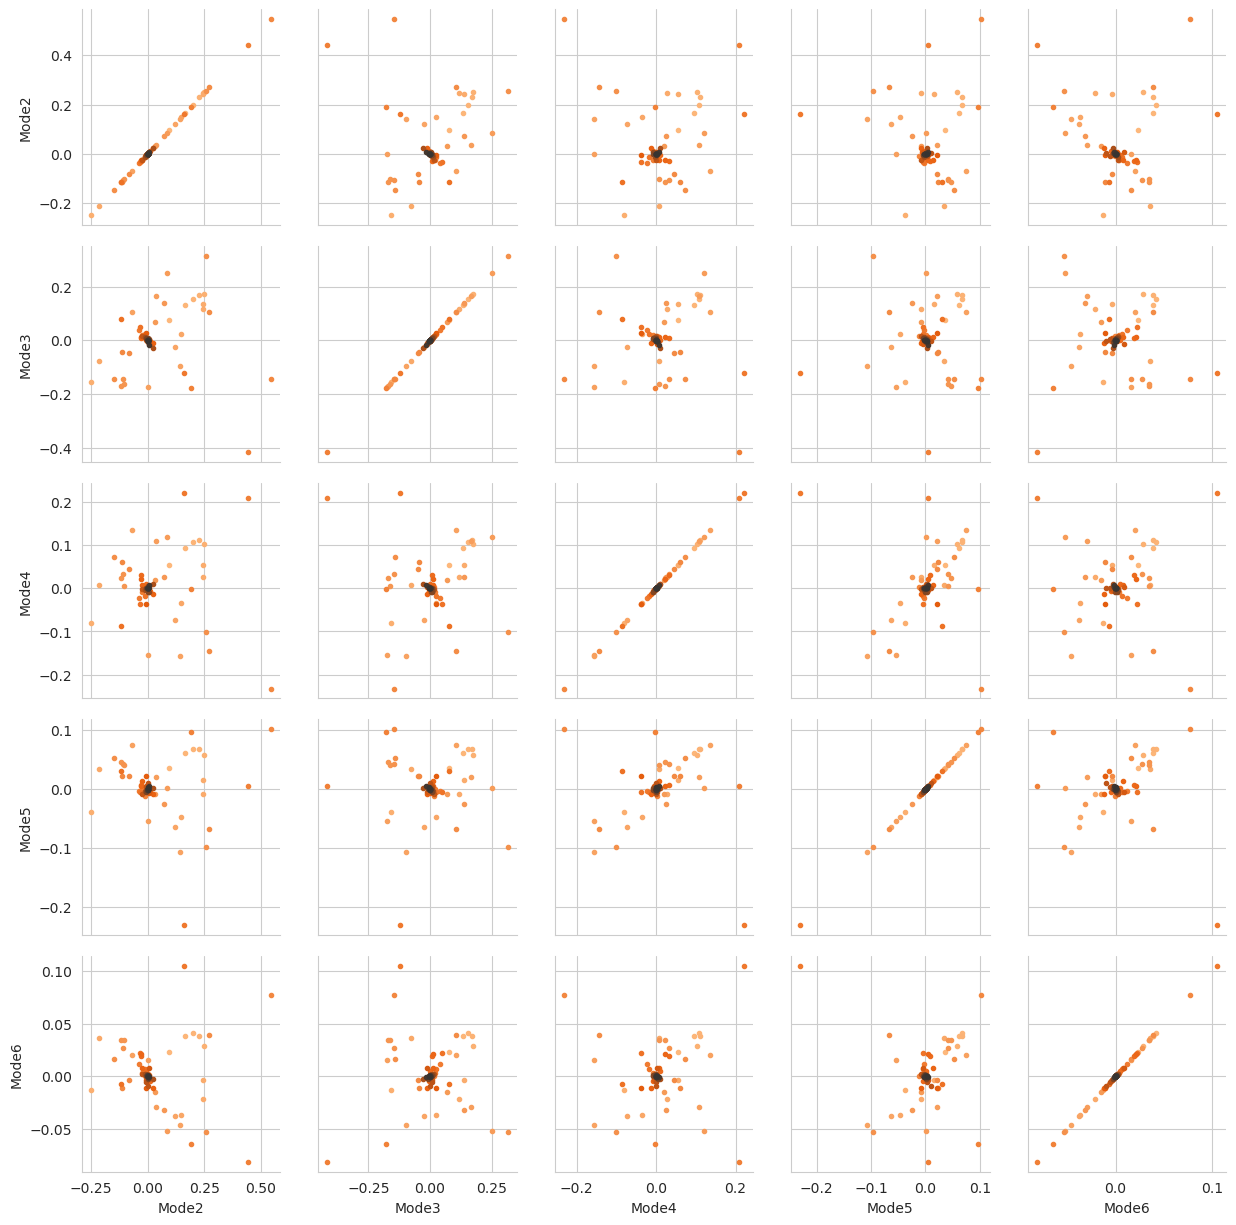

In [8]:
import seaborn as sns

g = sns.PairGrid(df, hue='Time (ps)', 
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df)))
g.map(plt.scatter, marker='.')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Ronald&nbsp;R. Coifman and Stéphane Lafon.
Diffusion maps.
<em>Applied and Computational Harmonic Analysis</em>, 21(1):5–30, July 2006.
02271.
<a href="https://doi.org/10.1016/j.acha.2006.04.006">doi:10.1016/j.acha.2006.04.006</a>.

[3] J.&nbsp;de&nbsp;la Porte, B.&nbsp;M. Herbst, W.&nbsp;Hereman, and S.&nbsp;J. van&nbsp;der Walt.
An introduction to diffusion maps.
In <em>In <span class="bibtex-protected">The</span> 19th <span class="bibtex-protected">Symposium</span> of the <span class="bibtex-protected">Pattern</span> <span class="bibtex-protected">Recognition</span> <span class="bibtex-protected">Association</span> of <span class="bibtex-protected">South</span> <span class="bibtex-protected">Africa</span></em>. 2008.
00038.

[4] Andrew Ferguson, Athanassios&nbsp;Z. Panagiotopoulos, Ioannis&nbsp;G. Kevrekidis, and Pablo&nbsp;G. Debenedetti.
Nonlinear dimensionality reduction in molecular simulation: <span class="bibtex-protected">The</span> diffusion map approach.
<em>Chemical Physics Letters</em>, 509(1-3):1–11, June 2011.
00085.
<a href="https://doi.org/10.1016/j.cplett.2011.04.066">doi:10.1016/j.cplett.2011.04.066</a>.

[5] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[6] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.

[7] Mary&nbsp;A. Rohrdanz, Wenwei Zheng, Mauro Maggioni, and Cecilia Clementi.
Determination of reaction coordinates via locally scaled diffusion map.
<em>The Journal of Chemical Physics</em>, 134(12):124116, March 2011.
00220.
<a href="https://doi.org/10.1063/1.3569857">doi:10.1063/1.3569857</a>.

[8] Douglas&nbsp;L. Theobald.
Rapid calculation of <span class="bibtex-protected">RMSDs</span> using a quaternion-based characteristic polynomial.
<em>Acta Crystallographica Section A Foundations of Crystallography</em>, 61(4):478–480, July 2005.
00127.
URL: <a href="http://scripts.iucr.org/cgi-bin/paper?S0108767305015266">http://scripts.iucr.org/cgi-bin/paper?S0108767305015266</a>, <a href="https://doi.org/10.1107/S0108767305015266">doi:10.1107/S0108767305015266</a>.